In [1]:
#pip install webdriver-manager --break-system-packages
#!pip install webdriver-manager --break-system-packages

# 작년문제 기록

# 문제1
### SUBWAY ‘매장찾기’ page 내에 있는 전체매장에 대한 정보를 crawling하여 아래 제시된 세부 기능을 만족하도록 파이썬 코드를 적성하시오.(30점)
* rawling page : 써브웨이 > 써브웨이> 매장찾기 
* 초기 page URL :  https://www.subway.co.kr/storeSearch?page=1&rgn1Nm=&rgn2Nm=#storeList
* 마지막 page URL: https://www.subway.co.kr/storeSearch?page=63&rgn1Nm=&rgn2Nm=#storeList

1) 연락처 항목에 “Coming Soon”인 매장을 제외한 모든 매장(2024년 10월 29일 기준 621개 매장)의  NO, 매장명, 매장주소, 주요서비스, 연락처 정보를 추출하여, 24시간 서비스를 제공하는 매장과 그렇지 않은 매장을 구분하여 pandas dataframe으로 생성하고 CSV파일로 출력하시오.
※ 23 page 402번 매장
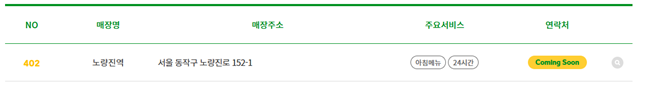
2) pandas dataframe 의 index는 ‘매장번호’, column 속성은 [매장명, 매장주소, 24시간서비스, 연락처]로 구성하고, ‘24시간서비스’ 속성 항목에는 ‘24시간’ 서비스를 지원하는 매장의 경우 ‘YES’, 지원하지 않는 경우 ‘NO’로 표기될 수 있도록 처리하세요.
  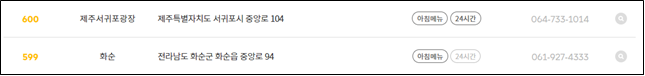
  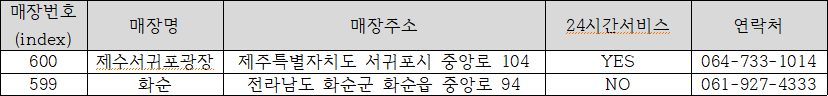
3) ‘24시간’ 서비스를 지원하는 매장의 수와 지원하지 않는 매장의 수를 구분하여 화면에 출력하세요. tip ) groupby 사용 권장.
4) ‘24시간’ 서비스를 지원하는 매장의 모든 정보를 csv파일(cp979 인코딩)로 저장하세요. tip) 논리 indexing  사용 권장.

In [10]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time

# Chrome WebDriver 설정
driver = webdriver.Chrome()

# 전체 매장 정보를 저장할 리스트
all_stores = []

# 1페이지부터 3페이지까지 크롤링
for page in range(1, 3):
    url = f"https://www.subway.co.kr/storeSearch?page={page}&rgn1Nm=&rgn2Nm=#storeList"
    print(f"크롤링 중: {page}페이지")
    
    driver.get(url)
    
    # 페이지 로딩 대기
    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "store_list"))
        )
        time.sleep(1)  # 추가 대기
    except:
        print(f"{page}페이지 로딩 실패")
        continue
    
    # 페이지 소스 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 매장 리스트 추출
    store_list = soup.select('#storeList > div > div > div.content > table')
    #print(len(store_list))
    
    for store in store_list:
        try:
            # NO (매장번호)
            no = store.select_one('td:nth-of-type(1)').text.strip()
            
            # 매장명
            store_name = store.select_one('td:nth-of-type(2)').text.strip()
            
            # 매장주소
            address = store.select_one('td:nth-of-type(3)').text.strip()
            
            # 주요서비스
            services = store.select_one('td:nth-of-type(4)').text.strip()
            
            # 연락처
            contact = store.select_one('td:nth-of-type(5)').text.strip()
            
            # "Coming Soon" 매장 제외
            if contact == "Coming Soon":
                continue
            
            # 24시간 서비스 여부 판단
            if '24시간' in services:
                service_24h = 'YES'
            else:
                service_24h = 'NO'
            
            # 매장 정보 저장
            all_stores.append({
                '매장번호': no,
                '매장명': store_name,
                '매장주소': address,
                '24시간서비스': service_24h,
                '연락처': contact
            })
            
        except Exception as e:
            print(f"매장 정보 추출 오류: {e}")
            continue

driver.quit()

# DataFrame 생성 (매장번호를 index로 설정)
df = pd.DataFrame(all_stores)
#print(df.columns)
#print(df.head())
df = df.set_index('매장번호')

print(f"\n총 크롤링된 매장 수: {len(df)}개")
print("\n=== 24시간 서비스 제공 여부별 매장 수 ===")

# groupby로 24시간 서비스 여부별 매장 수 출력
service_count = df.groupby('24시간서비스').size()
print(service_count)

# 24시간 서비스 제공 매장만 필터링 (논리 인덱싱)
df_24h = df[df['24시간서비스'] == 'YES']
print(f"\n24시간 서비스 제공 매장: {len(df_24h)}개")
print(f"24시간 서비스 미제공 매장: {len(df) - len(df_24h)}개")

# CSV 파일로 저장 (cp949 인코딩)
df_24h.to_csv('./subway_24h_stores.csv', encoding='cp949')

print("\n24시간 서비스 제공 매장 정보가 'subway_24h_stores.csv' 파일로 저장되었습니다.")

# 결과 확인
print("\n=== 24시간 서비스 제공 매장 샘플 ===")
print(df_24h.head())

크롤링 중: 1페이지
크롤링 중: 2페이지

총 크롤링된 매장 수: 2개

=== 24시간 서비스 제공 여부별 매장 수 ===
24시간서비스
YES    2
dtype: int64

24시간 서비스 제공 매장: 2개
24시간 서비스 미제공 매장: 0개

24시간 서비스 제공 매장 정보가 'subway_24h_stores.csv' 파일로 저장되었습니다.

=== 24시간 서비스 제공 매장 샘플 ===
       매장명                  매장주소 24시간서비스           연락처
매장번호                                                  
657   제주삼화  제주특별자치도 제주시 도련이동 543     YES  064-724-5439
647   구미사곡       경북 구미시 상사서로 169     YES  054-715-6666


table태그를 우클릭했어. 여기서 어떻게 해야해?

11:58 PM
"Copy selector" 클릭해봐!
그러면 해당 요소의 CSS selector가 복사돼. 그걸 코드의 .store_list tbody tr 부분에 붙여넣으면 돼. 아니면 "Copy outerHTML" 눌러서 전체 HTML 구조를 확인할 수도 있어!

# 문제2
### SUBWAY ‘매장찾기’ page 내에 있는 매장에 대한 정보를 crawling하여 아래 제시된 세부 기능을 만족하도록 파이썬 코드를 적성하시오.(30점)
1) selenium을 이용하여 1번 문제와 유사하게 진행해야하는 문제입니다.
   * 초기 URL : https://www.subway.co.kr/
   * selenium / web driver를 통해 크롬 브라우저에서 초기 URL을 시작 페이지로 설정하여 진행하세요.
   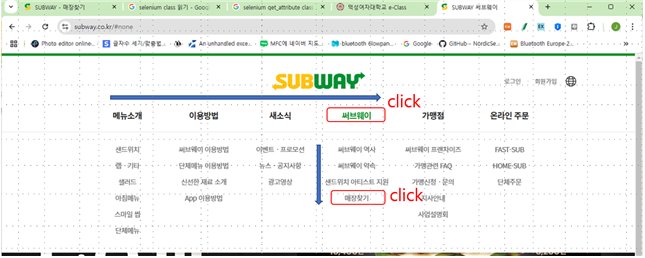
2) 메뉴 항목 click 시 “써브웨이”, “매장찾기” 라는 문자열을 찾아 비교 후 click 될 수 있도록 구현하세요.
   * tip) 해당하는 li 를 찾고 for 문을 사용하여 text 추출 후 비교 -> click
   * 해당하는 키워드를 찾았으면 모든 for문을 break를 통해 빠져나오세요. 
   * 2)번 항목을 만족하지 못할 경우, 해당 메뉴를 직접 선택하여 click하는 방식으로 구현할 경우 부분 점수 인정
3) 1 ~ 10 화면에 해당하는 매장명만 추출하여 list 자료형 구성하고, 이 list를 pandas Series 형식으로 변환하고 화면에 출력하시오. 
   * tip) 우리가 사용하고 있는 web driver (for 크롬)는 현재 보이는 브라우저의 내용(HTML)을 driver 객체를 통해 접근할 수 있습니다. URL이 바뀌지 않고 HTML 내용이 바뀌는 경우 및 python code를 통해 실행시킨 크롬 브라우저 내 URL이 바뀌는 경우에도 바뀐 URL에 대한 HTML 내용을 driver로 가져올 수 있습니다.
   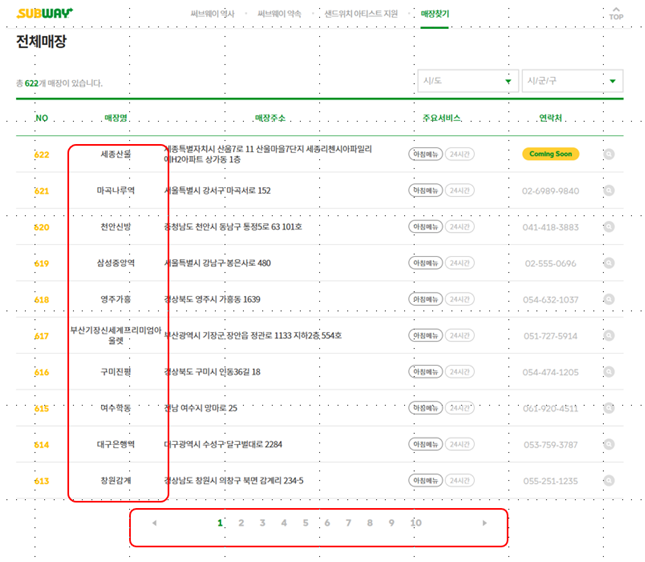

In [11]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time

# Chrome WebDriver 설정
driver = webdriver.Chrome()

# 초기 URL 접속
driver.get("https://www.subway.co.kr/")
time.sleep(2)

# 2) 메뉴 항목 클릭 - "써브웨이" 찾기
try:
    menu_items = driver.find_elements(By.CSS_SELECTOR, "nav li")
    
    for menu in menu_items:
        if "써브웨이" in menu.text:
            menu.click()
            time.sleep(1)
            print("'써브웨이' 메뉴 클릭 완료")
            break
    
    # "매장찾기" 찾기
    sub_menu_items = driver.find_elements(By.CSS_SELECTOR, "nav li")
    
    for sub_menu in sub_menu_items:
        if "매장찾기" in sub_menu.text:
            sub_menu.click()
            time.sleep(2)
            print("'매장찾기' 메뉴 클릭 완료")
            break
            
except Exception as e:
    print(f"메뉴 클릭 오류: {e}")

# 3) 1~10 페이지의 매장명 추출
store_names = []

for page in range(1, 3):
    print(f"{page}페이지 크롤링 중...")
    
    # 페이지 URL로 이동
    url = f"https://www.subway.co.kr/storeSearch?page={page}&rgn1Nm=&rgn2Nm=#storeList"
    driver.get(url)
    
    # 페이지 로딩 대기
    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "storeList"))
        )
        time.sleep(1)
    except:
        print(f"{page}페이지 로딩 실패")
        continue
    
    # 현재 페이지의 HTML 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 매장명 추출
    stores = soup.select('#storeList > div > div > div.content > table > colgroup')
    
    for store in stores:
        try:
            # 두 번째 td가 매장명
            name = store.select('td')[1].text.strip()
            store_names.append(name)
        except:
            continue

driver.quit()

# pandas Series로 변환
store_series = pd.Series(store_names)

print(f"\n총 추출된 매장 수: {len(store_series)}개")
print("\n=== 매장명 Series ===")
print(store_series)

'써브웨이' 메뉴 클릭 완료
1페이지 크롤링 중...
2페이지 크롤링 중...

총 추출된 매장 수: 0개

=== 매장명 Series ===
Series([], dtype: object)
